# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Team:** Group 5  
**Authors:** Chun-Hung Yeh, Kuan Tung, Zhuoyue Wang  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Import required packages

In [1]:
import tarfile
import os

import cv2 as cv
import numpy as np
import skimage.io
from skimage import measure, transform, morphology
from scipy import ndimage
import pandas as pd
from skimage.measure import regionprops
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

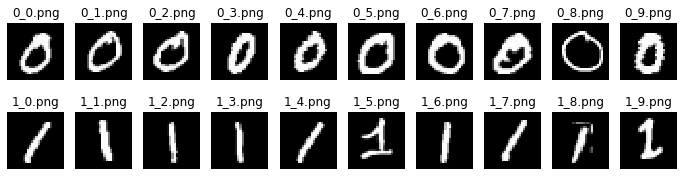

In [3]:
# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors

First we apply some pre-processing on the image to get a cleaner contour. They include thresholding and removing small objects using morphology.

The threshold value is decided using Otsu's binarization. This algorithm tried to minimize the the weighted within-class variance. It will loop through all the possible threshold values (1-256), calculate the weighted within-class variance, and pick the value such that variances to both classes are minimal.

In [4]:
def preprocessing(im):
    """Preprocessing on the image to get a better contour."""
    # binarize the image with an automatically computed threshold
    _, im = cv.threshold(im, 0, 1, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # remove small noises by morphology
    im = morphology.remove_small_objects(im.astype(bool), min_size=10)
    return im

The next step is finding all the contours and pick the longest one. The skimage.measure.find_contours function will return a list of all the contours represented by a series of points.

In [5]:
def find_contour(im):
    """Find the longest contour in the image."""
    # find contours and pick the longest contour
    contours = sorted(measure.find_contours(im, 0), key=lambda c: c.shape[0], reverse=True)
    contour = contours[0]
    return contour

Finally, we compute the Fourier descriptors with the following steps,  
1. Convert all the points into complex numbers.
2. Apply discrete Fourier transform.
3. Normalize the absolute value of the third and forth coefficients by the second one.

We skip the first coefficient because it is affected by translations. We use the absolte values because phases are affected by rotations. We normalize such that the descriptors can be invariant to scaling.

In [6]:
def compute_fourier_descriptors(im):
    """Compute 2-dimensional Fourier descriptors."""
    im = preprocessing(im)
    contour = find_contour(im)
    # convert to complex numbers
    points = contour[:, 1] + 1j * contour[:, 0]
    descriptors = np.fft.fft(points)
    # normalize the third and forth coefficients by the second one
    features = abs(descriptors[2:4]) / abs(descriptors[1])
    return features

Now we can compute the features and plot them on a 2D graph.

In [7]:
def plot_2d_graph_without_transform(feat_func, title, xlabel, ylabel):
    """Plot features on a 2D graph wihtout applying any transformation."""
    zeros_feat = np.array(list(map(feat_func, zeros_im)))
    ones_feat = np.array(list(map(feat_func, ones_im)))
    plt.scatter(zeros_feat[:, 0], zeros_feat[:, 1], label='zeros')
    plt.scatter(ones_feat[:, 0], ones_feat[:, 1], label='ones')
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

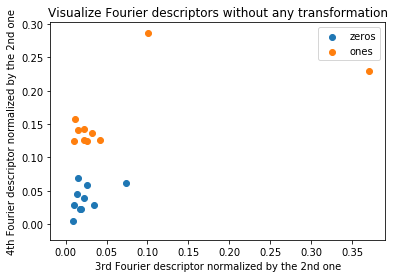

In [8]:
plot_2d_graph_without_transform(
    compute_fourier_descriptors,
    'Visualize Fourier descriptors without any transformation',
    xlabel='3rd Fourier descriptor normalized by the 2nd one',
    ylabel='4th Fourier descriptor normalized by the 2nd one'
)

We can see two clusters of zeros and ones. They can be easily separated by a linear function. However, there are two outliers for ones. Let's check the original images and see why this is the case.

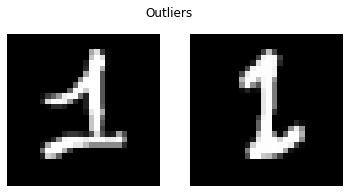

In [9]:
# check the outliers
ones_feat = np.array(list(map(compute_fourier_descriptors, ones_im)))
outliers = ones_im[ones_feat[:, 1] > 0.2]
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle('Outliers')
for i in range(2):
    axes[i].imshow(outliers[i], cmap='gray')
    axes[i].axis('off')

It turns out that these two one images are written in a different way compared with others. We can still separate them from zeros but it might result in some problems when we apply transformations.

In the following part, we apply translation, rotation and scaling to the images to see how our features handle these transformations.

In [10]:
def custom_rescale(im, scale):
    """Custom rescale function which preserves original shape."""
    output = np.zeros_like(im, dtype='uint8')
    rescaled = transform.rescale(im, scale, preserve_range=True, multichannel=False)
    new_dim = rescaled.shape[0]
    start_dim = int(im.shape[0] / 2 * (1 - scale))
    output[start_dim:start_dim + new_dim, start_dim:start_dim + new_dim] = rescaled
    return output

In [11]:
# apply transformation
# translation: translate by (2, -2)
translation_transform = transform.AffineTransform(translation=(2, -2))
translated_zeros_im = np.array(list(map(lambda im: transform.warp(im, translation_transform, preserve_range=True), zeros_im)), dtype='uint8')
translated_ones_im = np.array(list(map(lambda im: transform.warp(im, translation_transform, preserve_range=True), ones_im)), dtype='uint8')
# rotation: rotate by 90 degree (counterclockwise)
rotated_zeros_im = np.array(list(map(lambda im: transform.rotate(im, 90, order=5, preserve_range=True), zeros_im)), dtype='uint8')
rotated_ones_im = np.array(list(map(lambda im: transform.rotate(im, 90, order=5, preserve_range=True), ones_im)), dtype='uint8')
# scaling: scale by 0.75
scaled_zeros_im = np.array(list(map(lambda im: custom_rescale(im, 0.75), zeros_im)), dtype='uint8')
scaled_ones_im = np.array(list(map(lambda im: custom_rescale(im, 0.75), ones_im)), dtype='uint8')

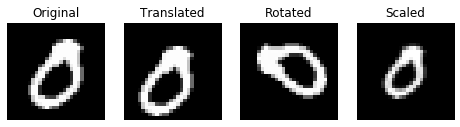

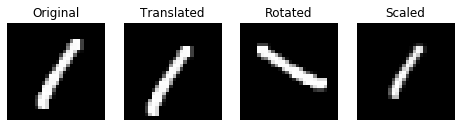

In [12]:
# show example images after the transformation
plot_name = ['Original', 'Translated', 'Rotated', 'Scaled']
all_zeros_im = [zeros_im, translated_zeros_im, rotated_zeros_im, scaled_zeros_im]
all_ones_im = [ones_im, translated_ones_im, rotated_ones_im, scaled_ones_im]
fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    axes[i].imshow(all_zeros_im[i][0], cmap='gray')
    axes[i].set_title(plot_name[i])
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    axes[i].imshow(all_ones_im[i][0], cmap='gray')
    axes[i].set_title(plot_name[i])
    axes[i].axis('off')
plt.show()

In [13]:
def plot_2d_graph_with_transformation(feat_func, title, xlabel, ylabel):
    """Plot features on a 2D graph when applying transformations on the images."""
    # compute features of normal and transformed images
    zeros_feat = np.array(list(map(feat_func, zeros_im)))
    ones_feat = np.array(list(map(feat_func, ones_im)))
    translated_zeros_feat = np.array(list(map(feat_func, translated_zeros_im)))
    translated_ones_feat = np.array(list(map(feat_func, translated_ones_im)))
    rotated_zeros_feat = np.array(list(map(feat_func, rotated_zeros_im)))
    rotated_ones_feat = np.array(list(map(feat_func, rotated_ones_im)))
    scaled_zeros_feat = np.array(list(map(feat_func, scaled_zeros_im)))
    scaled_ones_feat = np.array(list(map(feat_func, scaled_ones_im)))

    # group features in list for plotting
    all_zeros_feat = [translated_zeros_feat, rotated_zeros_feat, scaled_zeros_feat]
    all_ones_feat = [translated_ones_feat, rotated_ones_feat, scaled_ones_feat]

    # plot all the features
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(title)
    for i in range(3):
        axes[i].scatter(zeros_feat[:, 0], zeros_feat[:, 1], label='original zeros')
        axes[i].scatter(ones_feat[:, 0], ones_feat[:, 1], label='original ones')
        axes[i].scatter(all_zeros_feat[i][:, 0], all_zeros_feat[i][:, 1], label=['translated ', 'rotated ', 'scaled '][i] + 'zeros')
        axes[i].scatter(all_ones_feat[i][:, 0], all_ones_feat[i][:, 1], label=['translated ', 'rotated ', 'scaled '][i] + 'ones')
        axes[i].legend(loc='best')
        axes[i].set_title(['translation', 'rotation', 'scaling'][i])
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
    plt.show()

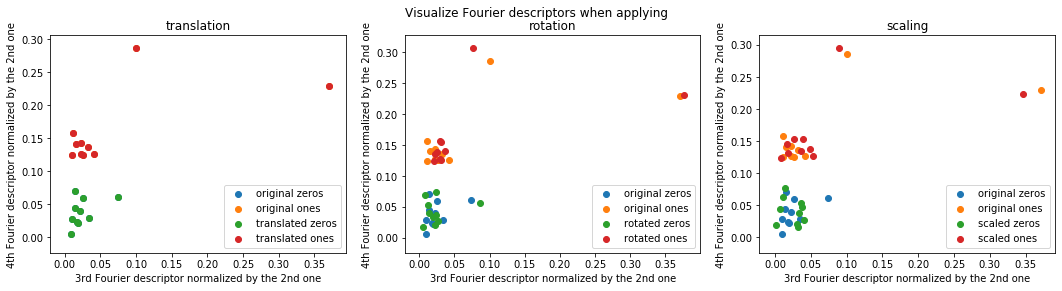

In [14]:
plot_2d_graph_with_transformation(
    compute_fourier_descriptors,
    'Visualize Fourier descriptors when applying',
    xlabel='3rd Fourier descriptor normalized by the 2nd one',
    ylabel='4th Fourier descriptor normalized by the 2nd one'
)

Translation: The translated features are exactly the same as the original ones, so our implementation of Fourier descriptors is invariant to translation.

Rotation: The rotated features are slightly different than the original ones. This could be because the contours of the rotated images are slightly different. However, the differences are not significant, we can still claim our implementation of Fourier descriptors is invariant to rotation.  

Scaling: The results are similar to the case in rotation. The scaled features are slightly different than the original ones because of the differences in contours (maybe it is caused by a fixed resolution). However, the differences are not significant, we can still claim our implementation of Fourier descriptors is invariant to scaling.

### 1.3 Additional method(s)
Add your implementation and discussion

#### 1. Region-based descriptors (perimeter and area)

In [15]:
def compute_area_compacity(im):
    """Compute area and compacity."""
    im = preprocessing(im)
    contour = find_contour(im)
    perimeter = contour.shape[0]
    contour = np.expand_dims(contour.astype(np.float32), 1)
    # Convert it to UMat object
    contour = cv.UMat(contour)
    area = cv.contourArea(contour)
    compacity = perimeter ** 2 / area
    return np.array([area, compacity])

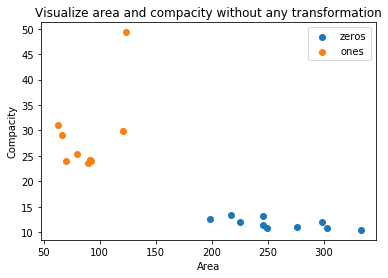

In [16]:
plot_2d_graph_without_transform(
    compute_area_compacity,
    'Visualize area and compacity without any transformation',
    xlabel='Area',
    ylabel='Compacity'
)

We can separate zeros and ones using perimeter and area as features.

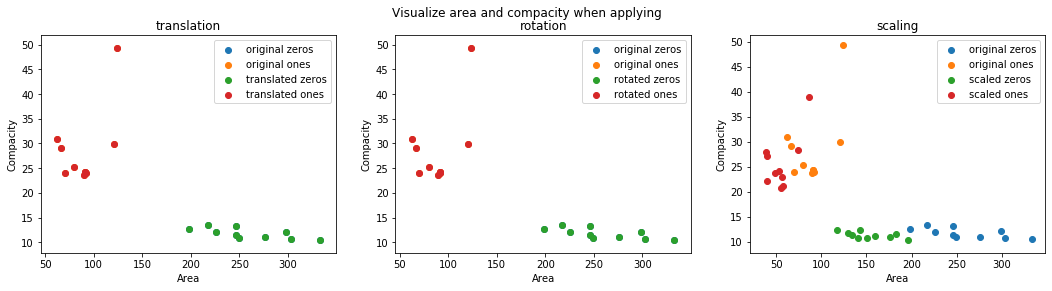

In [17]:
plot_2d_graph_with_transformation(
    compute_area_compacity,
    'Visualize area and compacity when applying',
    xlabel='Area',
    ylabel='Compacity'
)

Area and compacity are invariant to translation and rotation. The features of translated and rotated images are the same as the original ones.  

It seems like that compacity is also invariant to scaling, but area is not for a obvious reason. The area of the object will decrease when the image is scaled down.

#### 2. Region-based descriptors (rectangularity and elongation)

In [18]:
def compute_rectangularity_elongation(im):
    """Compute rectangularity and elongation."""
    im = preprocessing(im)
    contour = find_contour(im)
    perimeter = contour.shape[0]
    contour = np.expand_dims(contour.astype(np.float32), 1)
    # Convert it to UMat object
    contour = cv.UMat(contour)
    area = cv.contourArea(contour)
    xcoor, ycoor, width, height = cv.boundingRect(contour)
    rect_area = width * height
    rectangularity = float(area) / rect_area
    moments = cv.moments(contour)
    elongation = 2 * moments['mu11'] / (moments['mu20'] - moments['mu02'])
    return np.array([rectangularity, elongation])

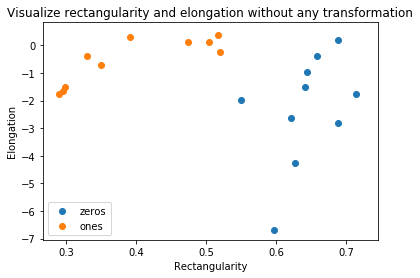

In [19]:
plot_2d_graph_without_transform(
    compute_rectangularity_elongation,
    'Visualize rectangularity and elongation without any transformation',
    xlabel='Rectangularity',
    ylabel='Elongation'
)

We can separate zeros and ones using rectangularity and elongation as features.

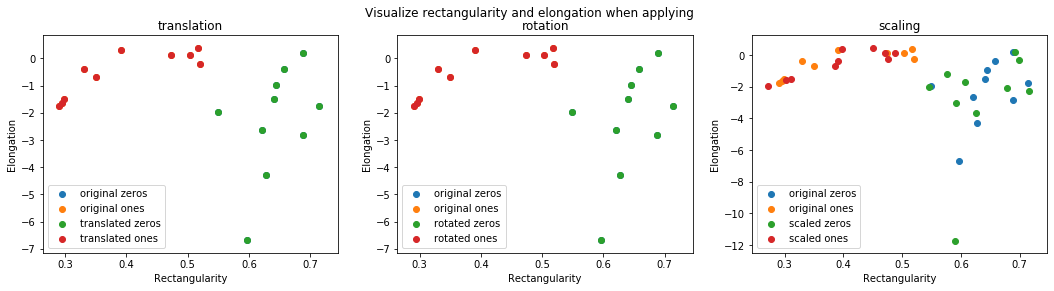

In [20]:
plot_2d_graph_with_transformation(
    compute_rectangularity_elongation,
    'Visualize rectangularity and elongation when applying',
    xlabel='Rectangularity',
    ylabel='Elongation'
)

Rectangularity and elongation are invariant to translation and rotation. The features of translated and rotated images are the same as the original ones.

It seems like that elongation is invariant to scaling and rectangularity is not. Because most of the differences in the scaling graph are from rectangularity. The rectangularity of zeros decreases after scaling and the rectangularity of ones increases after scaling.

#### 3. Region-based descriptors (compacity and rectangularity)

In [21]:
def rectangularity(img):
    # compute rectangularity to the given image
    contour, _ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    area = cv.contourArea(contour[0])
    x, y, w, h = cv.boundingRect(contour[0])
    rect_area = w * h
    return float(area)/rect_area


def extract_feature(img, func1, func2):
    # extract features of the given image using function 1 and function 2
    img_rotated = img_rotate(img)
    features = []
    for i in img_rotated:
        a1, a2 = func1(i), func2(i)
        features.append([a1, a2])
    features = np.array(features)
    return features, [func1.__name__, func2.__name__]

def plot_feature(img_featured, features, labels):
    plt.figure(figsize=(6, 4))
    for f, l in zip(img_featured, labels):
        if l == 0:
            plt.scatter(f[:,0], f[:,1], label = 'zeros')
        elif l == 1:
            plt.scatter(f[:,0], f[:,1], label = 'ones')
        elif l == 2:
            plt.scatter(f[:,0], f[:,1], label = 'twos')
        elif l == 3:
            plt.scatter(f[:,0], f[:,1], label = 'threes')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend(loc='best')
    plt.title('Visualize feature points without any transformation')
    plt.show()

def img_rotate(img):
    # return rotated images
    trans90  =  [transform.rotate(i, 90, resize=False, preserve_range=True).astype('uint8') for i in img]
    trans180 = [transform.rotate(i, 180, resize=False, preserve_range=True).astype('uint8') for i in img]
    trans270 = [transform.rotate(i, 270, resize=False, preserve_range=True).astype('uint8') for i in img]
    
    return  list(img) + trans90 + trans180 +trans270
def compacity(img):
    contour, _ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    area = cv.contourArea(contour[0])
    length = cv.arcLength(contour[0], True)
    return length**2/area

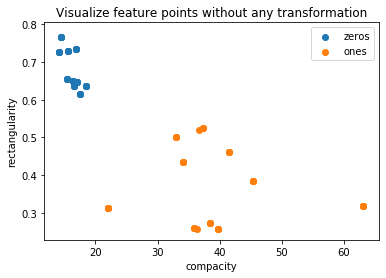

In [22]:
# augment two sets of images
img_augment = [zeros_im, ones_im]

imgs_f = []
for img in img_augment:
    img_f, f_name = extract_feature(img, compacity, rectangularity)
    imgs_f.append(img_f)

plot_feature(imgs_f, f_name, range(len(img_augment)))

We can separate zeros and ones by using rectangularity and compacity as features. This feature has obvious aggregation effect on zero

#### 4. Region-based descriptors (elongation and compacity)

In [23]:
def elongation(img):
    img = ndimage.grey_opening(img,size = (2,2))
    _, thresh = cv.threshold(img, 50, 255, cv.THRESH_BINARY)
    m = cv.moments(thresh)
    x = m['mu20'] + m['mu02']
    y = 4 * m['mu11']**2 + (m['mu20'] - m['mu02'])**2
    return (x + y**0.5) / (x - y**0.5)

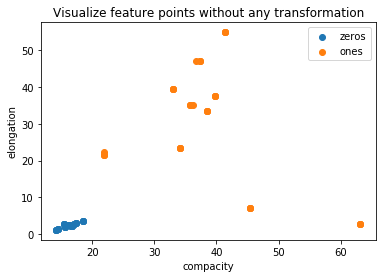

In [24]:
# augment two sets of images
img_augment = [zeros_im, ones_im]

imgs_f = []
for img in img_augment:
    img_f, f_name = extract_feature(img, compacity, elongation)
    imgs_f.append(img_f)

plot_feature(imgs_f, f_name, range(len(img_augment)))

We can separate zeros and ones by using elongation and compacity as features. This feature has obvious aggregation effect on zero but points of ones are too dispersive so it doesn't do well.

#### 5. Contour based descriptors (distance map using Chamfer distance)

In this section we would like to try the contour-based method using distance maps and Chamfer distance. First, we select two images from 0 and 1 as references. And then we obtain their distance maps by defining the skeletons and applying the function `distance_map`. So the other images of 0 and 1 are subsequently compared with these distance maps and measured their similarity, taking rotation and translation invariance into account.

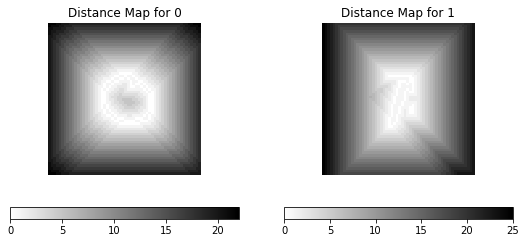

In [25]:
def distance_map(img_num):
    # build a distance map on img_num (0 or 1)
    img = np.ones((img_num.shape[0], img_num.shape[1]))
    contour, _ = cv.findContours(img_num, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    skeleton = cv.drawContours(img, contour, -1, (255, 255, 255), 1)
    skeleton = np.where(skeleton == 255, 0, 1)
    skeleton = np.pad(skeleton, (15, 15), 'edge')
    distance_map_num = ndimage.morphology.distance_transform_cdt(skeleton)
    return distance_map_num

# distance map for 0 and 1
distance_map_zero = distance_map(zeros_im[8, :, :])
distance_map_one = distance_map(ones_im[8,:,:])

# visualize
plt.figure(figsize = (9, 4))
plt.subplot(1, 2, 1)
plt.imshow(distance_map_zero, cmap = 'binary')
plt.title('Distance Map for 0')
plt.colorbar(orientation='horizontal')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(distance_map_one, cmap = 'binary')
plt.title('Distance Map for 1')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.show()

Now, let's calculate the similarity of the other images comparing with the references above. We try to find the optimal transformation of the images minimizing the distance with respect to both references. In the end, the min distance will be the feature used to classify the images.

In [26]:
def similarity(img1, img2, prev_distance, angle, i, j):
    # compute the similarity between img1 and img 2
    distance = np.sum(img1*img2)
    if distance < prev_distance:
        return distance, angle, i, j
    else: 
        return None
    
def find_optimal_trans(distance_map_num, shift_x, shift_y, skeleton, m):
    # search the optimal transformation for the template (0 or 1) to the given images
    prev_distance = np.sum(distance_map_num.ravel()) 
    
    # translation and rotation
    for i in range(0, distance_map_num.shape[0] - shift_x):
        for j in range(0, distance_map_num.shape[1] - shift_y):
            for angle in np.arange(0, 360, 10):
                img_rot = skimage.transform.rotate((skeleton.astype('float')), angle, resize = True)
                img_rot = np.where(img_rot >= np.mean(img_rot), 1, 0)
                if (img_rot.shape > skeleton.shape) & ((i+img_rot.shape[0] <= distance_map_num.shape[0]) & (j+img_rot.shape[1] <= distance_map_num.shape[1])):
                    if similarity(img_rot, distance_map_num[i:i+img_rot.shape[0], j:j+img_rot.shape[1]], prev_distance, angle, i, j) != None:
                        min_distance, min_angle, min_trasl_x, min_trasl_y = similarity(img_rot, distance_map_num[i:i+img_rot.shape[0], j:j+img_rot.shape[1]], prev_distance, angle, i, j)
                        prev_distance = min_distance
                elif (img_rot.shape == skeleton.shape):
                    if (similarity(img_rot, distance_map_num[i:i+shift_x, j:j+shift_y], prev_distance, angle, i, j) != None): 
                        min_distance, min_angle, min_trasl_x, min_trasl_y = similarity(img_rot, distance_map_num[i:i+shift_x, j:j+shift_y], prev_distance, angle, i, j)
                        prev_distance = min_distance
    print('Angle:{} and translation:[{},{}] => min_distance:{}'.format(min_angle, min_trasl_x, min_trasl_y, prev_distance))            
    return min_distance

In [27]:
features = pd.DataFrame(index = np.arange(0, len(zeros_im)+len(ones_im)), columns = ['Feature 1','Feature 2'])
image = np.ones((zeros_im[8, :, :].shape[0], zeros_im[8, :, :].shape[1]))

# all zero images:
for m in range(len(zeros_im)):
    #find the contour of the image and threhsolding the contour
    contour, _ = cv.findContours(zeros_im[m,:,:], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    skeleton = cv.drawContours(image-1, contour, -1, (255, 255, 255), 1)
    skeleton = np.where(skeleton == 255, 1, 0)
    
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
        
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    print('\n(0) For Feature 1 on image0_{}'.format(m))
    min_distance = find_optimal_trans(distance_map_zero, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], m)
    features.iloc[m, 0] = min_distance
    print('\n(0) For Feature 2 on image0_{}'.format(m))
    min_distance = find_optimal_trans(distance_map_one, shift_x, shift_y, skeleton[minr:maxr, minc:maxc], m)
    features.iloc[m, 1] = min_distance
    image = np.ones((zeros_im[8, :, :].shape[0], zeros_im[8, :, :].shape[1]))
    

# all one images
image = np.ones((ones_im[8, :, :].shape[0], ones_im[8, :, :].shape[1]))
for n in range(len(ones_im)):
    #find the contour of the image and threhsolding the contour
    contour, _ = cv.findContours(ones_im[n,:,:], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    skeleton = cv.drawContours(image-1, contour, -1, (255,255,255), 1)
    skeleton = np.where(skeleton==255, 1, 0)
    
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
        
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    print('\n(1) For Feature 1 on image1_{}'.format(n))
    min_distance = find_optimal_trans(distance_map_zero, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], n)
    features.iloc[m+n+1, 0] = min_distance
    print('\n(1) For Feature 2 on image1_{}'.format(n))
    min_distance = find_optimal_trans(distance_map_one, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], n)
    features.iloc[m+n+1, 1] = min_distance
    image=np.ones((ones_im[8, :, :].shape[0], ones_im[8, :, :].shape[1]))


(0) For Feature 1 on image0_0
Angle:180 and translation:[19,20] => min_distance:104

(0) For Feature 2 on image0_0
Angle:0 and translation:[20,22] => min_distance:120

(0) For Feature 1 on image0_1
Angle:0 and translation:[20,23] => min_distance:111

(0) For Feature 2 on image0_1
Angle:0 and translation:[20,21] => min_distance:153

(0) For Feature 1 on image0_2
Angle:0 and translation:[18,19] => min_distance:124

(0) For Feature 2 on image0_2
Angle:180 and translation:[19,22] => min_distance:170

(0) For Feature 1 on image0_3
Angle:180 and translation:[18,20] => min_distance:118

(0) For Feature 2 on image0_3
Angle:0 and translation:[20,22] => min_distance:91

(0) For Feature 1 on image0_4
Angle:180 and translation:[18,20] => min_distance:111

(0) For Feature 2 on image0_4
Angle:180 and translation:[20,21] => min_distance:105

(0) For Feature 1 on image0_5
Angle:0 and translation:[19,20] => min_distance:111

(0) For Feature 2 on image0_5
Angle:180 and translation:[20,21] => min_distan

<Figure size 432x288 with 0 Axes>

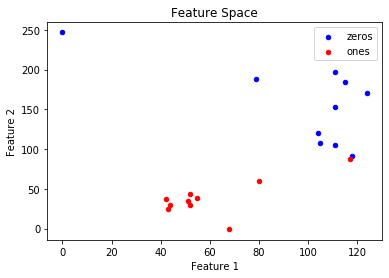

In [63]:
plt.figure(figsize=(6,4))
ax = features.iloc[0:len(zeros_im), :].plot.scatter(x = 'Feature 1', y = 'Feature 2', c = 'Blue',label='zeros')
features.iloc[len(ones_im)::, :].plot.scatter(x = 'Feature 1', y = 'Feature 2', c = 'Red', ax = ax, label='ones')
plt.title('Feature Space')
plt.show()

From our result, two clusters are able to be classified, though one point in red may be misclassified. After several trials, this method is prone to the references we choose, implying that it's hard to find appropriate images as the references. In addition, here we only consider the rotation and translation invariance since it's difficult to resize images in our implentation. 

#### 6. Contour based descriptors (chain code using edition distance)
We also try out another contour-based method using chain codes and edit distances. First, we transform each image into a series of codes by the function `chain_rule`. Then, compute the edit distance between two codes, reflecting minimum number of elementary operations necessary to transform one to the other. To finalize our result, here we choose the compacity and edit distance as our features for classification.

In [29]:
def chain_rule(img):
    # transform img to a chain code
    _, img = cv.threshold(img, 70, 255, 0)
    
    # find the first pixel on the boundary of the object 
    for i, row in enumerate(img):
        for j, value in enumerate(row):
            if value == 255:
                start_point = (i, j)
                break
                
    directions = [0, 1, 2, 7, 3, 6, 5, 4]
    dir2idx = dict(zip(directions, range(len(directions))))
    change_j = [-1,  0,  1, # change in x
                -1,      1,
                -1,  0,  1]

    change_i = [-1, -1, -1, # change in y
                 0,      0,
                 1,  1,  1]

    border = []
    chain = []
    string = str()

    # chain code: find the first point
    curr_point = start_point
    
    # for direction in directions:
    for direction in range(8):
        idx = dir2idx[direction]
        new_point = (start_point[0]+change_i[idx], start_point[1]+change_j[idx])
        if img[new_point] != 0:
            border.append(new_point)
            chain.append(direction)
            string = str(direction)
            curr_point = new_point
            break

    count = 0
    
    # while the coordinates of the current pixel are not equal to those of the starting pixel
    while curr_point != start_point:
        # figure direction to start search
        # the aim of (direction + 5) % 8 is to find the pairs:0-4; 1-5; 2-6; 3-7
        # For example: assume that direction of start point to the first point is 0. 
        # Therefore the direction of the first point to start point is 4, 
        # we need start search from 5-8 and then 0-4
        b_direction = (direction + 5) % 8 
        dirs_1 = range(b_direction, 8)
        dirs_2 = range(0, b_direction)
        dirs = []
        dirs.extend(dirs_1)
        dirs.extend(dirs_2)
        for direction in dirs:
            idx = dir2idx[direction]
            new_point = (curr_point[0]+change_i[idx], curr_point[1]+change_j[idx])
            if img[new_point] != 0: 
                border.append(new_point)
                chain.append(direction)
                string += str(direction)
                curr_point = new_point
                break
        if count == 1000: break
        count += 1
    return string


def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 
            deletions = current_row[j] + 1     
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
        
    return previous_row[-1]


def morphology2(img, sizes, threshold):
    _, thres = cv.threshold(img, threshold, 255, cv.THRESH_BINARY)
    img = ndimage.grey_closing(thres, size = sizes)
    return img


def edit_distance(img, reference_im, function):
    img_distance = []
    
    # morphology of the reference image
    _, thresh = cv.threshold(reference_im, 45, 255, cv.THRESH_BINARY)
    reference_im = ndimage.grey_opening(thresh, size = (2,2))
    comparison = chain_rule(reference_im)
    
    # calculate the edit distance for each contour after rotation 
    for i in img:
        dist_list = []
        _, thresh2 = cv.threshold(i, 45, 255, cv.THRESH_BINARY)
        i = ndimage.grey_opening(thresh2, size = (2, 2))
        
        # rotation
        for j in range(10, 360, 10):
            try:
                img_rotated = transform.rotate(i, j, preserve_range = True)
                img_string = chain_rule(img_rotated)
                distance = levenshtein(img_string, comparison)
                dist_list.append([distance])
            except:
                continue
        parameter = function(i)
        img_distance.append([parameter, np.min(dist_list)])
    return np.array(img_distance)


def compacity(img):
    contour, _ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    area = cv.contourArea(contour[0])
    length = cv.arcLength(contour[0], True)
    return length**2/area

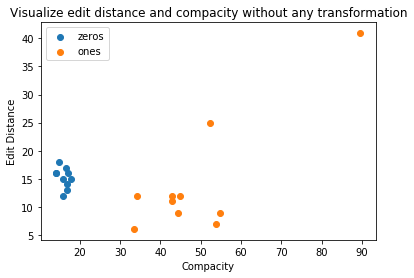

In [30]:
# compute edit distance for 0 and 1
zeros_distance = edit_distance(zeros_im, zeros_im[1], compacity)
ones_distance = edit_distance(ones_im, ones_im[1], compacity)

# visualize
plt.figure(figsize=(6,4))
plt.scatter(zeros_distance[:,0], zeros_distance[:,1], label='zeros')
plt.scatter(ones_distance[:,0], ones_distance[:,1],  label='ones')
plt.ylabel('Edit Distance')
plt.xlabel('Compacity')
plt.legend(loc='best')
plt.title('Visualize edit distance and compacity without any transformation')
plt.show()

Based on our result, we could successfully classify the images of class 0 and 1. Additionally, we find out that the distribution of the cluster 0 is much condensed while the one of cluster 1 is more widespread, which reflects larger in-cluster variance.

#### 7. Principal component analysis
We use principal component analysis for all images to project features in 2D space.

In [31]:
def PCA2d(x):
    # The shape of x should be (num_samples, num_features)
    pca = PCA(n_components=2)
    pca.fit(x)
    feature = pca.transform(x)
    return feature

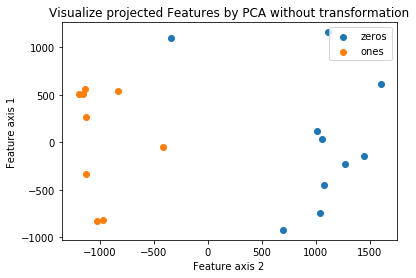

In [32]:
all_ims = np.concatenate((zeros_im, ones_im), 0).reshape((20,-1))
feature = PCA2d(all_ims)
plt.figure(figsize=(6, 4))
plt.scatter(feature[:10, 0], feature[:10, 1],label='zeros')
plt.scatter(feature[11:, 0], feature[11:, 1],label='ones')
plt.ylabel('Feature axis 1')
plt.xlabel('Feature axis 2')
plt.legend(loc='best')

# for i, (zero) in enumerate(feature[:10]):
#     plt.annotate('zero'+str(i), (zero[0], zero[1]))
# for i, (one) in enumerate(feature[11:]):
#     plt.annotate('one'+str(i), (one[0], one[1]))
plt.title('Visualize projected Features by PCA without transformation')
plt.show()

From the above result, we could successfully classify the images of class 0 and 1. However, Clusters are not condensed enough to separate two clusters easily. Both two classes(cluster) have a significant variation (nodes are not very concentrated).

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

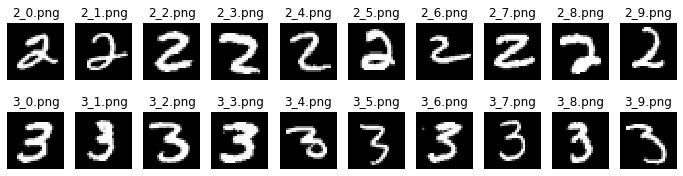

In [33]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

#### 1. Fourier Descriptors

In [34]:
def plot_2d_graph_without_transform_part_2(feat_func, title, xlabel, ylabel):
    """Plot features on a 2D graph wihtout applying any transformation (for 4 digits)."""
    zeros_feat = np.array(list(map(feat_func, zeros_im)))
    ones_feat = np.array(list(map(feat_func, ones_im)))
    twos_feat = np.array(list(map(feat_func, twos_im)))
    threes_feat = np.array(list(map(feat_func, threes_im)))
    plt.scatter(zeros_feat[:, 0], zeros_feat[:, 1], label='zeros')
    plt.scatter(ones_feat[:, 0], ones_feat[:, 1], label='ones')
    plt.scatter(twos_feat[:, 0], twos_feat[:, 1], label='twos')
    plt.scatter(threes_feat[:, 0], threes_feat[:, 1], label='threes')
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

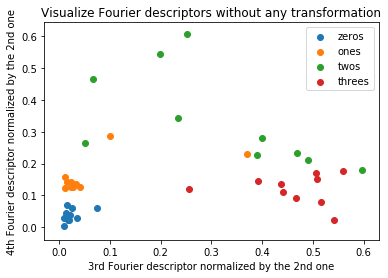

In [35]:
plot_2d_graph_without_transform_part_2(
    compute_fourier_descriptors,
    'Visualize Fourier descriptors without any transformation',
    xlabel='3rd Fourier descriptor normalized by the 2nd one',
    ylabel='4th Fourier descriptor normalized by the 2nd one'
)

We can still separate these four digits in the graph. However, there will be some errors, like the two ones that are closer to the cluster of twos. Maybe it will be better if we add one more dimension to the features.

In [36]:
def compute_3d_fourier_descriptors(im):
    """Compute 3-dimensional Fourier descriptors."""
    im = preprocessing(im)
    contour = find_contour(im)
    # convert to complex numbers
    points = contour[:, 1] + 1j * contour[:, 0]
    descriptors = np.fft.fft(points)
    # normalize the third, forth and fifth coefficients by the second one
    features = abs(descriptors[2:5]) / abs(descriptors[1])
    return features

In [37]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_graph_without_transform(feat_func, title, xlabel, ylabel, zlabel):
    """Plot features on a 2D graph wihtout applying any transformation (for 4 digits)."""
    zeros_feat = np.array(list(map(feat_func, zeros_im)))
    ones_feat = np.array(list(map(feat_func, ones_im)))
    twos_feat = np.array(list(map(feat_func, twos_im)))
    threes_feat = np.array(list(map(feat_func, threes_im)))
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(zeros_feat[:, 0], zeros_feat[:, 1], zeros_feat[:, 2], label='zeros')
    ax.scatter(ones_feat[:, 0], ones_feat[:, 1], ones_feat[:, 2], label='ones')
    ax.scatter(twos_feat[:, 0], twos_feat[:, 1], twos_feat[:, 2], label='twos')
    ax.scatter(threes_feat[:, 0], threes_feat[:, 1], threes_feat[:, 2], label='threes')
    plt.legend(loc='best')
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()

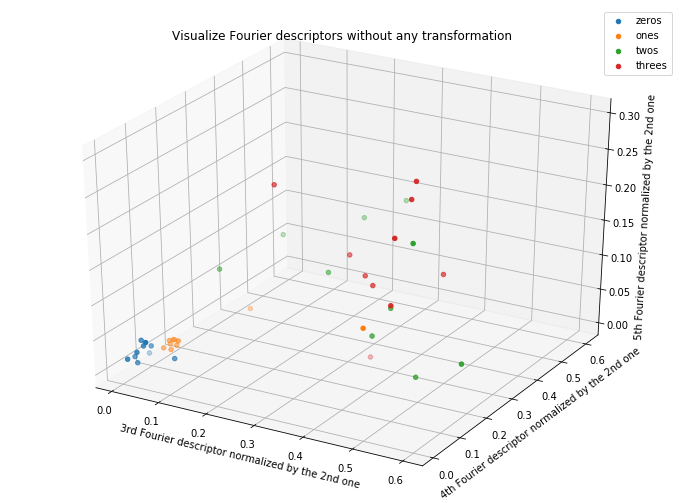

In [38]:
plot_3d_graph_without_transform(
    compute_3d_fourier_descriptors,
    'Visualize Fourier descriptors without any transformation',
    xlabel='3rd Fourier descriptor normalized by the 2nd one',
    ylabel='4th Fourier descriptor normalized by the 2nd one',
    zlabel='5th Fourier descriptor normalized by the 2nd one'
)

Adding another dimension is helpful in separating zeros and ones from twos and threes. But it doesn't help much when it comes to separating twos and threes.

#### 2. Region-based descriptors (perimeter and area)

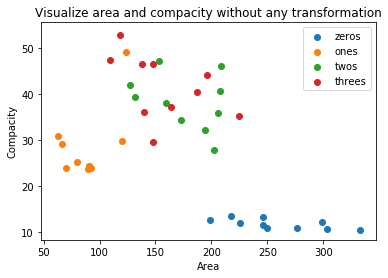

In [39]:
plot_2d_graph_without_transform_part_2(
    compute_area_compacity,
    'Visualize area and compacity without any transformation',
    xlabel='Area',
    ylabel='Compacity'
)

We can separate zeros and maybe ones from the other digits, but twos and threes are mixed together.

#### 3. Region-based descriptors (rectangularity and elongation)

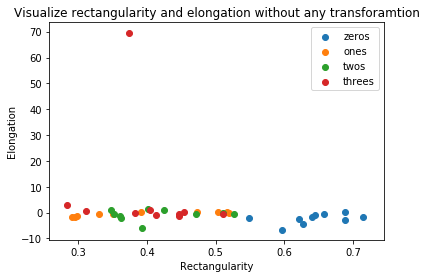

In [40]:
plot_2d_graph_without_transform_part_2(
    compute_rectangularity_elongation,
    'Visualize rectangularity and elongation without any transforamtion',
    xlabel='Rectangularity',
    ylabel='Elongation'
)

We can only separate zeros from the other digits. Ones, twos and threes are mixed together, so this is definitely not a good descriptors.

#### 4. Region-based descriptors (compacity and rectangularity)

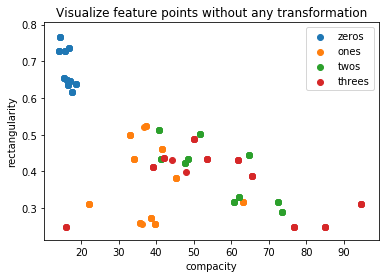

In [41]:
# augment two sets of images
img_augment = [zeros_im, ones_im, twos_im, threes_im,]

imgs_f = []
for img in img_augment:
    img_f, f_name = extract_feature(img, compacity, rectangularity)
    imgs_f.append(img_f)

plot_feature(imgs_f, f_name, range(len(img_augment)))

Also, it cannot separate well for all these numbers.

#### 5. Region-based descriptors (elongation and compacity)

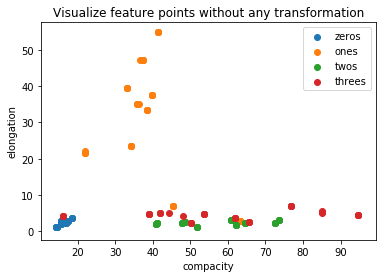

In [42]:
# augment two sets of images
img_augment = [zeros_im, ones_im, twos_im, threes_im]

imgs_f = []
for img in img_augment:
    img_f, f_name = extract_feature(img, compacity, elongation)
    imgs_f.append(img_f)

plot_feature(imgs_f, f_name, range(len(img_augment)))

It doesn't do well in separating all numbers.

#### 6. Contour based descriptors (distance map using Chamfer distance)
We apply the same method as we did in the part 1.

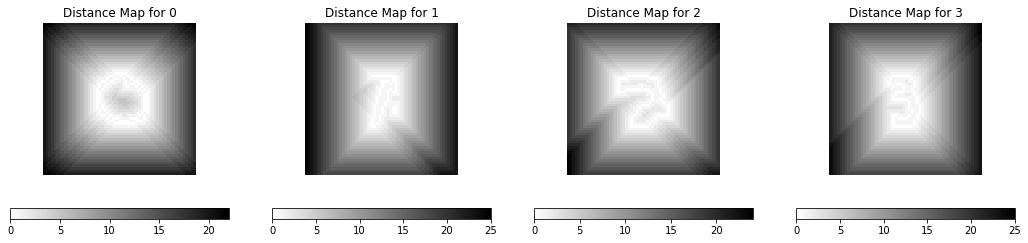

In [43]:
# distance map for 0, 1, 2, 3
distance_map_zero = distance_map(zeros_im[8, :, :])
distance_map_one = distance_map(ones_im[8,:,:])
distance_map_two = distance_map(twos_im[8, :, :])
distance_map_three = distance_map(threes_im[8,:,:])



# visualize
plt.figure(figsize = (18, 4))
plt.subplot(1, 4, 1)
plt.imshow(distance_map_zero, cmap = 'binary')
plt.title('Distance Map for 0')
plt.colorbar(orientation='horizontal')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(distance_map_one, cmap = 'binary')
plt.title('Distance Map for 1')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.subplot(1, 4, 3)
plt.imshow(distance_map_two, cmap = 'binary')
plt.title('Distance Map for 2')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.subplot(1, 4, 4)
plt.imshow(distance_map_three, cmap = 'binary')
plt.title('Distance Map for 3')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.show()

In [44]:
features2 = pd.DataFrame(index = np.arange(0, len(twos_im)+len(threes_im)), columns = ['Feature 0','Feature 1'])
image = np.ones((twos_im[8, :, :].shape[0], twos_im[8, :, :].shape[1]))

# all zero images:
for m in range(len(twos_im)):
    #find the contour of the image and threhsolding the contour
    contour, _ = cv.findContours(twos_im[m,:,:], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    skeleton = cv.drawContours(image-1, contour, -1, (255, 255, 255), 1)
    skeleton = np.where(skeleton == 255, 1, 0)
    
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
        
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    print('\n(2) For Feature 0 on image2_{}'.format(m))
    min_distance = find_optimal_trans(distance_map_two, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], m)
    features2.iloc[m, 0] = min_distance
    print('\n(3) For Feature 1 on image2_{}'.format(m))
    min_distance = find_optimal_trans(distance_map_three, shift_x, shift_y, skeleton[minr:maxr, minc:maxc], m)
    features2.iloc[m, 1] = min_distance
    image = np.ones((twos_im[8, :, :].shape[0], twos_im[8, :, :].shape[1]))
    

# all one images
image = np.ones((threes_im[8, :, :].shape[0], threes_im[8, :, :].shape[1]))
for n in range(len(threes_im)):
    #find the contour of the image and threhsolding the contour
    contour, _ = cv.findContours(threes_im[n,:,:], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    skeleton = cv.drawContours(image-1, contour, -1, (255,255,255), 1)
    skeleton = np.where(skeleton==255, 1, 0)
    
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
        
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    print('\n(3) For Feautre 0 on image3_{}'.format(n))
    min_distance = find_optimal_trans(distance_map_two, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], n)
    features2.iloc[m+n+1, 0] = min_distance
    print('\n(3) For Feature 1 on image3_{}'.format(n))
    min_distance = find_optimal_trans(distance_map_three, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], n)
    features2.iloc[m+n+1, 1] = min_distance
    image=np.ones((threes_im[8, :, :].shape[0], threes_im[8, :, :].shape[1]))


(2) For Feature 0 on image2_0
Angle:270 and translation:[20,21] => min_distance:84

(3) For Feature 1 on image2_0
Angle:270 and translation:[20,21] => min_distance:100

(2) For Feature 0 on image2_1
Angle:270 and translation:[19,19] => min_distance:93

(3) For Feature 1 on image2_1
Angle:0 and translation:[23,21] => min_distance:115

(2) For Feature 0 on image2_2
Angle:180 and translation:[20,18] => min_distance:108

(3) For Feature 1 on image2_2
Angle:180 and translation:[20,18] => min_distance:125

(2) For Feature 0 on image2_3
Angle:0 and translation:[20,18] => min_distance:77

(3) For Feature 1 on image2_3
Angle:180 and translation:[20,20] => min_distance:119

(2) For Feature 0 on image2_4
Angle:180 and translation:[20,19] => min_distance:71

(3) For Feature 1 on image2_4
Angle:180 and translation:[20,18] => min_distance:80

(2) For Feature 0 on image2_5
Angle:0 and translation:[20,21] => min_distance:89

(3) For Feature 1 on image2_5
Angle:0 and translation:[20,20] => min_distanc

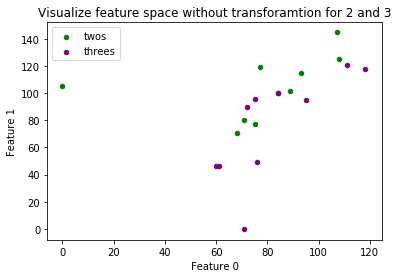

In [60]:
ax = features2.iloc[0:len(twos_im), :].plot.scatter(x = 'Feature 0', y = 'Feature 1', c = 'Green', label='twos')
features2.iloc[len(threes_im)::, :].plot.scatter(x = 'Feature 0', y = 'Feature 1', c = 'Purple', ax = ax, label='threes')
plt.title('Visualize feature space without transforamtion for 2 and 3')
plt.show()

Sadly, we could not perform well for the classification between class 2 and 3. The clusters are mixed together.

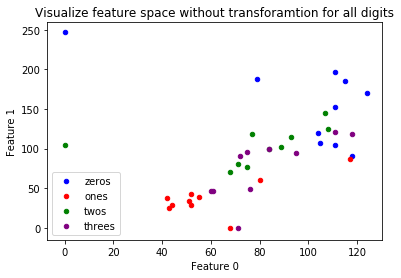

In [61]:
# all digits
ax = features.iloc[0:len(zeros_im), :].plot.scatter(x = 'Feature 1', y = 'Feature 2', c = 'Blue',label='zeros')
features.iloc[len(ones_im)::, :].plot.scatter(x = 'Feature 1', y = 'Feature 2', c = 'Red', ax = ax, label='ones')
features2.iloc[0:len(twos_im), :].plot.scatter(x = 'Feature 0', y = 'Feature 1', c = 'Green', ax = ax, label='twos')
features2.iloc[len(threes_im)::, :].plot.scatter(x = 'Feature 0', y = 'Feature 1', c = 'Purple', ax = ax, label='threes')
plt.title('Visualize feature space without transforamtion for all digits')
plt.show()

Considering all 4 digits, we see that we are unable to classify them because the clusters of each digit are aligned together.

#### 7. Contour based descriptors (chain code using edition distance)
We apply the same method as we did in the part 1.

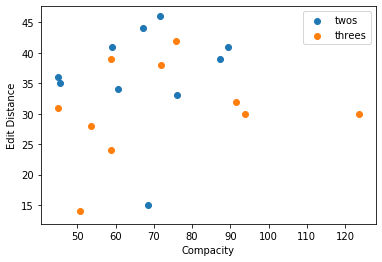

In [55]:
# compute edit distance for 2 and 3
twos_distance = edit_distance(twos_im, twos_im[1], compacity)
threes_distance = edit_distance(threes_im, threes_im[1], compacity)

# visualize
plt.figure(figsize=(6,4))
plt.scatter(twos_distance[:, 0], twos_distance[:, 1], label='twos')
plt.scatter(threes_distance[:, 0], threes_distance[:, 1],  label='threes')
plt.ylabel('Edit Distance')
plt.xlabel('Compacity')
plt.legend()
plt.show()

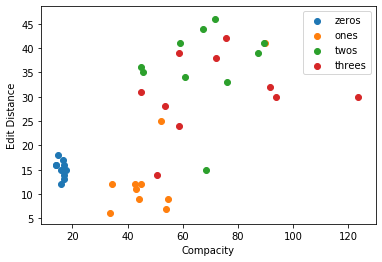

In [58]:
# visualize in the case for all digits
plt.figure(figsize=(6,4))
plt.scatter(zeros_distance[:, 0], zeros_distance[:, 1], label='zeros')
plt.scatter(ones_distance[:, 0], ones_distance[:, 1],  label='ones')
plt.scatter(twos_distance[:, 0], twos_distance[:, 1], label='twos')
plt.scatter(threes_distance[:, 0], threes_distance[:, 1],  label='threes')
plt.ylabel('Edit Distance')
plt.xlabel('Compacity')
plt.legend()
plt.show()

We could classify the cluster of digit 0. However, for the other digits, we could not because their clusters are mixed together.

#### 8. Principal component analysis

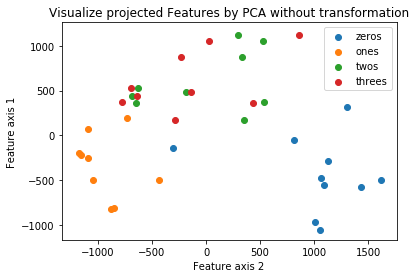

In [57]:
all_ims = np.concatenate((zeros_im, ones_im, twos_im, threes_im), 0).reshape((40,-1))
feature = PCA2d(all_ims)
plt.figure(figsize=(6, 4))
plt.scatter(feature[:10, 0], feature[:10, 1],label='zeros')
plt.scatter(feature[11:20, 0], feature[11:20, 1],label='ones')
plt.scatter(feature[21:30, 0], feature[31:40, 1],label='twos')
plt.scatter(feature[31:40, 0], feature[31:40, 1],label='threes')
plt.ylabel('Feature axis 1')
plt.xlabel('Feature axis 2')
plt.legend(loc='best')

# for i, (zero) in enumerate(feature[:10]):
#     plt.annotate('zero'+str(i), (zero[0], zero[1]))
# for i, (one) in enumerate(feature[11:]):
#     plt.annotate('one'+str(i), (one[0], one[1]))
plt.title('Visualize projected Features by PCA without transformation')
plt.show()

From the above result, we can see PCA cannot separate all these four numbers as feature points for different classes mix together.